### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import scipy
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import floyd_warshall
from scipy.optimize import minimize_scalar, minimize, root
pd.set_option('display.max_rows', None)

In [5]:
link_char = pd.read_excel('Link_characteristics_ver2.xlsx')
od_matrix_data = pd.read_excel('O_D_matrix_ver2.xlsx')
link_char['ca'] = link_char['ca'] * 1000
link_char['o'] = link_char['o'] - 1  ###adjustment for generating matrix for Flyod Warhsall-adopted
link_char['d'] = link_char['d'] - 1
link_char['link'] = link_char['link'] -1
od_matrix = od_matrix_data.values
od_nodes = od_matrix_data.columns - 1
#print(link_char)

In [6]:
#od_nodes

In [7]:
#od_matrix#

### User Equilibrium-Fuctions defined


In [8]:
def tt(df):
    t0 = np.array(df.t0)
    ca = np.array(df.ca)
    x = np.array(df.x)
    return np.multiply(t0,(1+ 0.15*(np.power(np.divide(x,ca),4))))

def converg_func(pre,nex):
    return np.sqrt(np.sum(np.power(np.subtract(pre,nex),2))) / np.sum(pre)

def return_tt(df):
    x_n = np.array(df['x'])
    t0 = np.array(df.t0)
    ca = np.array(df.ca)
    obj =  np.sum(np.multiply(t0,np.add(x_n,0.15*np.divide(np.power(x_n,5),np.power(ca,4)))))
    return obj
###-----function for genrating matrix for FW algorithm-only centeriod as OD-pairs rest masked-adopted
def fw_graph(df):
    n = 24
    graph = np.zeros([n, n])
    for i in range(len(df)):
        o = int(df.iloc[i]['o'])
        d = int(df.iloc[i]['d'])
        graph[o][d] = df.iloc[i]['t']
    fw_graph = np.ma.masked_values(graph,0)
    return csr_matrix(fw_graph)
####------function adopted for masking of matrix
   
def obj_func(alpha,df):
    y = np.array(df.y)
    x_n = np.array(df.x)
    t0 = np.array(df.t0)
    ca = np.array(df.ca)
    x_sub = np.add(x_n,alpha * np.subtract(y,x_n))
    obj = np.sum(np.multiply(t0,np.add(x_sub,(0.15/5)*np.divide(np.power(x_sub,5),np.power(ca,4)))))
    return obj

def plot_alpha(df):
    x_int = np.arange(0,1,0.1) 
    plt.plot(x_int,[obj_func(z,df) for z in x_int])
    plt.show()

In [10]:
## Initialization
link_char['x'] = 0
link_char['y'] = 0
obj = []
###
err = 300
loop = 1
ca = link_char['ca']
while err > 1e-4:
    print('loop-seq : ', loop)
    link_char['y'] = 0
    x_n = np.array(link_char['x'])
    link_char['t'] = tt(link_char) ##-column for travel time-
    csgraph = fw_graph(link_char)
    dist,pred = floyd_warshall(csgraph, directed=True, return_predecessors=True)
    ## Loop for all demands #pred is predecessor matrix from floyd warshal-adopted
    for i in range(od_matrix.shape[0]):
        for j in range(od_matrix.shape[1]):
            o = od_nodes[i]
            d = od_nodes[j]
            q = od_matrix[i][j]
            if q > 0:
                ## Extracting shortest path from FW predecessor matrix
                path = []
                p_data = d
                while p_data != -9999:
                    path.append(p_data)
                    p_data = pred[o][p_data] ## Floyd Warshall predecessor matrix
#                 print(path) ##next loop assigns flow to links on paths
                for k in range(len(path)-1):
                    dest = path[k] 
                    orig = path[k+1]
                    link_char.loc[(link_char.o==orig) & (link_char.d==dest),'y'] +=  q
            ### adopted-ends
    ## iteration for alpha
    if loop!= 1:
        alpha = minimize_scalar(obj_func,args=(link_char), bounds=(0.0, 1.0),method='bounded').x

    else:
        alpha = 1
        pred1 = pred
    print("Alpha : ",alpha)
    print("obj : ",obj_func(alpha,link_char))
    obj.append(obj_func(alpha,link_char))
    y = np.array(link_char['y'])
    x_n1= x_n + alpha * (y-x_n)
    link_char['x'] = x_n1 ## Update x to update t
    if loop != 1:
        err= converg_func(x_n,x_n1)
        print("err : ",err)
    loop += 1
link_char['ratio'] = link_char['x'] / link_char['ca']
print(link_char)

loop-seq :  1
Alpha :  1
obj :  1194319.9389856076
loop-seq :  2
Alpha :  0.3580495635474403
obj :  1215318.1350388648
err :  0.016952728359224234
loop-seq :  3
Alpha :  0.59539234826553
obj :  1213879.5817149691
err :  0.011918798060329848
loop-seq :  4
Alpha :  0.9999940391390134
obj :  1212309.73947231
err :  0.012324634275338553
loop-seq :  5
Alpha :  0.10948353233082492
obj :  1212182.2584607902
err :  0.0038375642825061057
loop-seq :  6
Alpha :  0.04484723222766715
obj :  1212175.6996291778
err :  0.000952548785576181
loop-seq :  7
Alpha :  0.023374865884427668
obj :  1212173.3956291708
err :  0.0005593599441825444
loop-seq :  8
Alpha :  0.16129196099856186
obj :  1212162.201663861
err :  0.0014545697418987555
loop-seq :  9
Alpha :  0.010736249669390177
obj :  1212161.473312859
err :  0.0002966013472921532
loop-seq :  10
Alpha :  0.05864427928948282
obj :  1212158.7141372736
err :  0.0006852393659092595
loop-seq :  11
Alpha :  0.008836776153989334
obj :  1212158.3480550067
err : 

Text(0, 0.5, 'Obj_func')

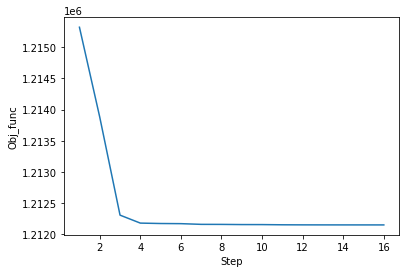

In [7]:
plt.plot(range(1,len(obj)),obj[1:])
plt.xlabel('Step')
plt.ylabel('Obj_func')

In [8]:
link_char[link_char['ratio'] > 0.9].loc[:,['link','t0','o','d','x','t','ratio']]


,link,t0,o,d,x,t,ratio
1,1,2.4,0,2,11470.984429,3.345564,1.273139
13,13,3.0,5,1,11390.000000,3.782097,1.148185
18,18,1.2,7,5,10720.000000,1.457720,1.093878
33,33,2.4,10,13,11226.226137,3.032447,1.151408
38,38,2.4,12,23,10330.000000,2.781692,1.014735
39,39,2.4,13,10,11006.317133,2.984048,1.128853
56,56,2.4,18,14,4739.284294,2.875653,1.072236
65,65,1.8,20,23,11647.348769,2.344697,1.192154
73,73,2.4,23,12,10330.000000,2.644419,0.907733
74,74,1.8,23,20,11526.531539,2.327597,1.179788


In [9]:
link_char.link += 1
link_char.o += 1
link_char.d += 1

In [7]:
#print(link_char.loc[:,['link','t0','o','d','x','t','ratio']].to_markdown())
#link_char.to_excel("proj1.xlsx")

In [11]:
link_char.link -= 1
link_char.o -= 1
link_char.d -= 1

### For SO

In [12]:
def obj_so(alpha,df): ##  Objective function for System Optimal
    y = np.array(df['y~'])
    x_n = np.array(df['x~'])
    t0 = np.array(df.t0)
    ca = np.array(df.ca)
    x_sub = np.add(x_n,alpha * np.subtract(y,x_n))
    obj = np.sum(np.multiply(t0,np.add(x_sub,(0.75/5)*np.divide(np.power(x_sub,5),np.power(ca,4)))))
    return obj

def tt_so(df): ## Function for t tilde
    t0 = np.array(df.t0)
    ca = np.array(df.ca)
    x = np.array(df['x~'])
    return np.multiply(t0,(1+ 0.75*(np.power(np.divide(x,ca),4))))

def tt(df): ## Function for travel time function
    t0 = np.array(df.t0)
    ca = np.array(df.ca)
    x = np.array(df['x~'])
    return np.multiply(t0,(1+ 0.15*(np.power(np.divide(x,ca),4))))

def fw_so(df):  ###
    n = 24
    graph = np.zeros([n, n])
    for i in range(len(df)):
        o = int(df.iloc[i]['o'])
        d = int(df.iloc[i]['d'])
        graph[o][d] = df.iloc[i]['t~']
    fw_graph = np.ma.masked_values(graph,0)
    return csr_matrix(fw_graph)

In [13]:
# Initialization
link_char['x~'] = 0
link_char['y~'] = 0
Z1 = []
###
err = 999
loop = 1
ca = link_char['ca']
while err > 1e-4:
    print('loop-seq : ', loop)
    link_char['y~'] = 0
    x_n = np.array(link_char['x~'])
    link_char['t~'] = tt_so(link_char)
    csgraph = fw_so(link_char)
    dist,pred = floyd_warshall(csgraph, directed=True, return_predecessors=True)
    ## Loop for all demands #pred is predecessor matrix from floyd warshal
    for i in range(od_matrix.shape[0]):
        for j in range(od_matrix.shape[1]):
            o = od_nodes[i]
            d = od_nodes[j]
            q = od_matrix[i][j]
            if q > 0:
                ## Extracting shortest path from FW predecessor matrixl
                path = []
                p_data = d
                while p_data != -9999:
                    path.append(p_data)
                    p_data = pred[o][p_data] ## Floyd Warshall predictions
#                 print(path)
                for k in range(len(path)-1):
                    dest = path[k] 
                    orig = path[k+1]
                    link_char.loc[(link_char.o==orig) & (link_char.d==dest),'y~'] +=  q
    ## Get alpha
    if loop!= 1:
        alpha = minimize_scalar(obj_so,args=(link_char), bounds=(0.0, 1.0),method='bounded').x
    else:
        alpha = 1
        pred1 = pred
    print("Alpha : ",alpha)
    print("Z : ",obj_so(alpha,link_char))
    Z1.append(obj_so(alpha,link_char))
    y = np.array(link_char['y~'])
    x_n1 = x_n + alpha * (y-x_n)
    link_char['x~'] = x_n1 ## Update x to update t
    if loop != 1:
        err= converg_func(x_n,x_n1)
        print("err : ",err)
    loop += 1
link_char['ratio_so'] = link_char['x~'] / link_char['ca']

loop-seq :  1
Alpha :  1
Z :  1195479.6949280372
loop-seq :  2
Alpha :  0.2658983516230175
Z :  1282833.1299742302
err :  0.02374315172803134
loop-seq :  3
Alpha :  0.5531748305055618
Z :  1269655.243901434
err :  0.01946169559855342
loop-seq :  4
Alpha :  0.2515735010396054
Z :  1265716.5428657543
err :  0.010487888417012536
loop-seq :  5
Alpha :  0.4096115226660674
Z :  1262319.113079462
err :  0.0112396852077767
loop-seq :  6
Alpha :  0.19784883529594732
Z :  1260409.6723060855
err :  0.008266525399063923
loop-seq :  7
Alpha :  0.3686784404667281
Z :  1259024.3953440122
err :  0.006776301708609967
loop-seq :  8
Alpha :  0.14915414412173517
Z :  1258223.3286681685
err :  0.005247434148567243
loop-seq :  9
Alpha :  0.15948451058789778
Z :  1257787.5029206593
err :  0.003983177963506581
loop-seq :  10
Alpha :  0.1378681684849004
Z :  1257411.8046668174
err :  0.003545840226875006
loop-seq :  11
Alpha :  0.11155717441034867
Z :  1257180.8145404393
err :  0.0029591522422397713
loop-seq :

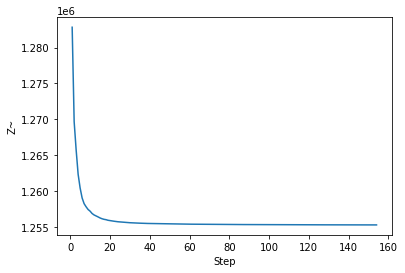

In [14]:
plt.plot(range(1,len(Z1)),Z1[1:],label='SO')
# plt.plot(range(1,len(T)),T[1:],label='UE')
plt.xlabel('Step')
plt.ylabel('Z~')
# plt.legend()
plt.show()

In [15]:
link_char['x_so'] = link_char['x~']
link_char['t_so'] = tt(link_char)

In [16]:
link_char.link += 1
link_char.o += 1
link_char.d += 1

In [17]:
link_char[link_char['ratio'] > 0.9].loc[:,['link','t0','o','d','x','t','ratio','x_so','t~','t_so','ratio_so']]


,link,t0,o,d,x,t,ratio,x_so,t~,t_so,ratio_so
1,2,2.4,1,3,11470.984429,3.345564,1.273139,10395.575685,5.583246,3.037966,1.153782
13,14,3.0,6,2,11390.000000,3.782097,1.148185,10176.560860,5.493161,3.498391,1.025863
18,19,1.2,8,6,10720.000000,1.457720,1.093878,9193.531673,1.899077,1.339411,0.938115
33,34,2.4,11,14,11226.226137,3.032447,1.151408,8901.363619,3.650769,2.650098,0.912960
38,39,2.4,13,24,10330.000000,2.781692,1.014735,10326.281002,4.305699,2.781142,1.014369
39,40,2.4,14,11,11006.317133,2.984048,1.128853,8938.418822,3.671819,2.654289,0.916761
56,57,2.4,19,15,4739.284294,2.875653,1.072236,3551.466362,3.150270,2.550053,0.803499
65,66,1.8,21,24,11647.348769,2.344697,1.192154,8849.437232,2.701393,1.981739,0.905777
73,74,2.4,24,13,10330.000000,2.644419,0.907733,10663.695945,3.787230,2.677565,0.937056
74,75,1.8,24,21,11526.531539,2.327597,1.179788,8548.111807,2.585002,1.958222,0.874935


In [8]:
#print(link_char.loc[:,['link','t0','o','d','x','t','ratio','x_so','t~','t_so','ratio_so']].to_markdown())
#link_char.to_excel("so.xlsx")

In [22]:
sum(link_char.x)/ sum(link_char['x~'])

0.9926947302264786

In [23]:
phi = sum(np.multiply(link_char.x,link_char.t)) / sum(np.multiply(link_char.x_so,link_char.t_so)) 
phi

1.0123017029408112

### First Best Tolling

In [24]:
link_char['toll'] = link_char['t~'] - link_char['t_so']

In [25]:
np.mean(np.array(link_char['toll']))

0.27317717808482667

In [9]:
#print(link_char.loc[:,['link','t0','o','d','x','t','ratio','x_so','t~','t_so','ratio_so','toll']].to_markdown())
#link_char.to_excel('toll.xlsx')

In [27]:
link_char.link -= 1
link_char.o -= 1
link_char.d -= 1

In [28]:
def obj_tau(alpha,df): ## Representing Z
    y = np.array(df['y_tau'])
    x_n = np.array(df['x_tau'])
    t0 = np.array(df.t0) 
    ca = np.array(df.ca)
    x_sub = np.add(x_n,alpha * np.subtract(y,x_n))
    obj = np.sum(np.add(np.multiply(t0,np.add(x_sub,(0.15/5)*np.divide(np.power(x_sub,5),np.power(ca,4)))),np.multiply(np.array(df.toll),x_sub)))
    return obj

def tt_toll(df): ## Representing t with toll
    t0 = np.array(df.t0)
    ca = np.array(df.ca)
    x = np.array(df['x_tau'])
    return np.add(np.multiply(t0,(1+ 0.15*(np.power(np.divide(x,ca),4)))), np.array(df.toll))

def tt(df): ## Representing t without toll
    t0 = np.array(df.t0)
    ca = np.array(df.ca)
    x = np.array(df['x_tau'])
    return np.multiply(t0,(1+ 0.15*(np.power(np.divide(x,ca),4))))

def fw_tau(df):
    n = 24
    graph = np.zeros([n, n])
    for i in range(len(df)):
        o = int(df.iloc[i]['o'])
        d = int(df.iloc[i]['d'])
        graph[o][d] = df.iloc[i]['t_tau']
    tau_matrix = np.ma.masked_values(graph,0)
    return csr_matrix(tau_matrix)

In [29]:
## Initialization
link_char['x_tau'] = 0
link_char['y_tau'] = 0
###
conv_test = 100
loop = 1
ca = link_char['ca']
while conv_test > 1e-4:
    print('loop : ', loop)
    link_char['y_tau'] = 0
    x_n = np.array(link_char['x_tau'])
    link_char['t_tau'] = tt_toll(link_char)
    csgraph = fw_tau(link_char)
    dist,pred = floyd_warshall(csgraph, directed=True, return_predecessors=True)
    ## Loop for all demands
    for i in range(od_matrix.shape[0]):
        for j in range(od_matrix.shape[1]):
            o = od_nodes[i]
            d = od_nodes[j]
            q = od_matrix[i][j]
            if q > 0:
                ## Extracting shortest path from FW predecessor matrix
                path = []
                p_data = d
                while p_data!= -9999:
                    path.append(p_data)
                    p_data = pred[o][p_data] ## Floyd Warshall predictions
#                 print(path)
                for k in range(len(path)-1):
                    orig = path[k] 
                    dest = path[k+1]
                    link_char.loc[(link_char.o==orig) & (link_char.d==dest),'y_tau'] +=  q
    ## Get alpha
    if loop!= 1:
        alpha = minimize_scalar(obj_tau,args=(link_char), bounds=(0.0, 1.0),method='bounded').x

    else:
        alpha = 1
        pred1 = pred
    print("Alpha : ",alpha)
    print("Z : ",obj_tau(alpha,link_char))
    y = np.array(link_char['y_tau'])
    x_n1 = x_n + alpha * (y-x_n)
    link_char['x_tau'] = x_n1 ## Update x to update t
    if loop != 1:
        conv_test= converg_func(x_n,x_n1)
        print("Conv : ",conv_test)
    loop += 1
link_char['ratio_toll'] = link_char['x_tau'] / link_char['ca']

loop :  1
Alpha :  1
Z :  1387432.0033197696
loop :  2
Alpha :  5.9608609865491405e-06
Z :  1401547.3984102735
Conv :  3.170739504873409e-07


In [30]:
link_char['t_toll'] = tt(link_char)

In [31]:
#link_char

,link,t0,ca,o,d,x,y,t,ratio,x~,...,t~,ratio_so,x_so,t_so,toll,x_tau,y_tau,t_tau,ratio_toll,t_toll
0,0,3.6,6020.0,0,1,4429.015571,4300,3.758320,0.735717,5507.338138,...,5.498634,0.914840,5507.338138,3.978246,1.520388,4299.991118,2810,5.260954,0.714284,3.740565
1,1,2.4,9010.0,0,2,11470.984429,11600,3.345564,1.273139,10395.575685,...,5.583246,1.153782,10395.575685,3.037966,2.545280,11600.008882,13090,5.934369,1.287459,3.389092
2,2,3.6,12020.0,1,0,4300.000000,4300,3.608844,0.357737,3089.474683,...,3.611803,0.257028,3089.474683,3.602357,0.009446,4300.012101,6330,3.618290,0.357738,3.608844
3,3,3.0,15920.0,1,5,11519.015571,11390,3.123372,0.723556,12594.424315,...,3.882803,0.791107,12594.424315,3.176260,0.706543,11389.991118,9900,3.824449,0.715452,3.117905
4,4,2.4,46810.0,2,0,11600.000000,11600,2.401358,0.247810,12813.439140,...,2.410102,0.273733,12813.439140,2.402021,0.008081,11599.987899,9570,2.409439,0.247810,2.401358
5,5,2.4,34220.0,2,3,7694.761399,7610,2.400921,0.224862,7357.797546,...,2.403836,0.215015,7357.797546,2.400769,0.003067,8560.008882,10050,2.404476,0.250146,2.401410
6,6,2.4,46810.0,2,11,11556.223030,11770,2.401337,0.246875,10817.588511,...,2.405134,0.231096,10817.588511,2.401027,0.004107,10820.000000,10820,2.405135,0.231147,2.401028
7,7,2.4,25820.0,3,2,8043.685974,7610,2.403395,0.311529,9438.628376,...,2.432141,0.365555,9438.628376,2.406429,0.025713,7609.993562,6530,2.428429,0.294733,2.402717
8,8,1.2,28250.0,3,4,14814.758557,14730,1.213616,0.524416,15050.528748,...,1.272402,0.532762,15050.528748,1.214501,0.057900,16269.996543,15690,1.277704,0.575929,1.219804
9,9,3.6,9040.0,3,10,6480.001918,6480,3.742568,0.716814,5311.465982,...,3.923385,0.587552,5311.465982,3.664354,0.259031,5890.000000,5890,3.956346,0.651549,3.697315


In [32]:
link_char.link += 1
link_char.o += 1
link_char.d += 1

In [10]:
#link_char[link_char.ratio >= 0.9].loc[:,['link','t0','o','d','x','t','ratio','x_so','t~','t_so','ratio_so','toll','x_tau','t_toll']]

In [34]:
link_char[link_char.ratio_so >= 0.9].to_excel("firs.xlsx")

In [11]:
#print(link_char.loc[:,['link','t0','o','d','ratio','x_so','t_so','ratio_so','toll','x_tau','t_toll','ratio_toll']].to_markdown())

In [36]:
link_char.to_excel("fisrt_comp.xlsx")